
**Problem Overvew:**
Within the company, there is a team that is responsible for defining product characteristics that will be built. For a blender category, for example, this team is responsible for setting the color, cup volume, cup material or even if you will have a filter to fruit juice.
To define the characteristics of the different product categories, the team seeks to understand when the customer is interested in a product. This is where the Data Science team is called. Your
main objective is to develop a model that can classify the product between "interesting" and "not interesting" given the attributes of it. In addition, it is desirable that you can also indicate which attributes and their values drive the customer's interest the most. 

**Problem Statement**

Develop a model that can classify the product between "interesting" and "not interesting" given the attributes of it. In addition, it is desirable to indicate which attributes and their values most drive customer interest.

1. Explore the database for insights that can guide you through the learning model creation phase.
2. Create a machine learning model can classify the product between "interesting" and "not interesting" given the attributes of the product.
3. Use metrics to analyze modeling results

I load all the packages that will be used throughout the modeling.

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

The code below allows me to load the dataset file that will be used in the analysis.

In [0]:
from google.colab import files
import io
import pandas as pd
uploaded = files.upload()


Saving problem1_dataset.csv to problem1_dataset.csv


**Exploratory data analysis**
The purpose of the exploratory analysis is:

1) Identify missing values, discrepant data or inconsistencies in our data.

2) At this stage, it is also possible to identify insights into our data.

The following code line reads the dataset that was loaded and shows their dimension.

In [0]:

data = pd.read_csv(io.BytesIO(uploaded['problem1_dataset.csv']))
print("Number of rows in data =",data.shape[0])
print("Number of columns in data =",data.shape[1])
data.head(8)

Number of rows in data = 180275
Number of columns in data = 21


,ITEM_ID,ALTURA,CAPACIDADE_(L),COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,SESSION_ID,ITEM_PRICE,INTERESTED
0,264220456,30.5,NaN,ALUMINIO,VINHO,NaN,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,86.709770,199.990000,0.0
1,238630912,22.0,NaN,ALUMINIO,COLORIDO,NaN,24.0,TRAMONTINA,No,no,150.0,40.0,12.0,NAO,NAO,1.0,PIPOQUEIRA,NAO,73.156401,105.112581,0.0
2,218228122,24.0,NaN,INOX,INOX,NaN,20.0,LA CUISINE,Yes,no,190.0,20.0,3.0,NAO,NAO,1.0,ESPAGUETEIRA,NAO,952.331024,139.990000,0.0
3,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,637.759106,103.293333,1.0
4,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,478.531428,103.330242,0.0
5,264220456,30.5,NaN,ALUMINIO,VINHO,NaN,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,914.936724,179.990000,0.0
6,254633548,30.5,NaN,ALUMINIO,AMARELO,REDONDO,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,793.755940,199.990000,0.0
7,788804,NaN,0.1,INOX,INOX,NaN,NaN,TRAMONTINA,No,no,NaN,NaN,NaN,NAO,NAO,0.0,CREMEIRA,NAO,473.772238,64.840000,0.0


Since we have text type attributes, let's turn text into upper-case text, to avoid problems when we are turning categorical variables into dummies variable.

In [0]:
categorical_list = data.select_dtypes(exclude=[np.number]).columns.tolist()
for col in categorical_list:
  data[col] = data[col].str.upper()

In the bottom row, we can see the number of NULL values per column. Filling in NULL values allows mitigating the effect of information loss. There are some techniques for treating missing values such as:

1) If the number of NULL values is insignificant, the values may be removed. 2) Null values can be replaced by the average of the values in that column. 3) Using interpolation methods to fill NULL values. 4) The most frequent category value or creating a new category for the case of categorical data.



We can observe that of the 20 attributes of the dataset, 14 of them have missing values and among them 6 are categorical attributes.

In [0]:
print(data.isnull().sum())

ITEM_ID                   0
ALTURA                 9268
CAPACIDADE_(L)       103604
COMPOSICAO            23297
COR                   10024
FORMATO               90264
LARGURA                9268
MARCA                   274
PARA_LAVA_LOUCAS      76189
PARA_MICRO_ONDAS      93873
PESO                  81751
PROFUNDIDADE           9268
TEMPO_GARANTIA        57505
TEM_FERRO_FUNDIDO         0
TEM_GRELHA                0
TEM_TAMPA                 0
TIPO_PRODUTO              0
TIPO_WOK                  0
SESSION_ID             2002
ITEM_PRICE            13097
INTERESTED                0
dtype: int64


In the graphs below we can observe the interest of people considering the attributes of the object. The "para_lava_louças" attribute has 3 categories Yes, No, No. This indicates that there was a typo. We will replace the value NO with NO.

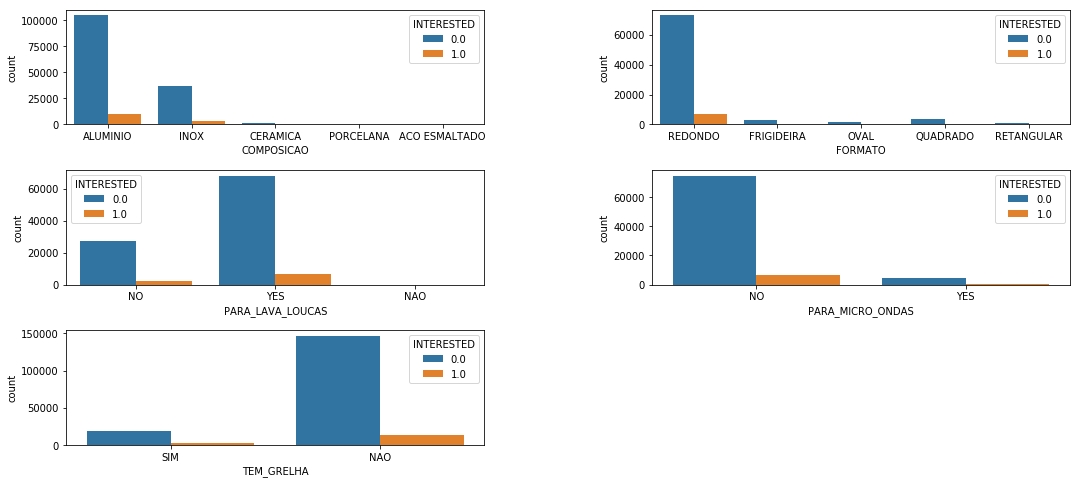

In [0]:
categorical_feature = ['COMPOSICAO','FORMATO', 'PARA_LAVA_LOUCAS',
                      'PARA_MICRO_ONDAS', 'TEM_GRELHA']
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(18, 8)
for j in range(0, len(categorical_feature)):
  ax = fig.add_subplot(3,2, j+1)
  sns.countplot(x=categorical_feature[j], hue="INTERESTED", data=data, ax = ax)

In [0]:
index = data[data['PARA_LAVA_LOUCAS']=='NAO'].index.tolist()
data.loc[index, 'PARA_LAVA_LOUCAS'] = 'NO'

**Exploring and Understanding Missing Data**

First we will begin by analyzing the columns with missing categorical data. To fill in such data we can obtain by two alternatives: 1) fill NULL data with the most frequent category. 2) Create a new category.

In the code below all null values have been replaced by the most frequent class in each column.

In [0]:
categ_feature_name = ['COMPOSICAO','COR', 'FORMATO', 'MARCA', 'PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS']
for column in categ_feature_name:
  most_common = data[column].value_counts().index[0]
  data[column] = data[column].replace(np.nan, most_common)

In [0]:
data.describe()

,ITEM_ID,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_TAMPA,SESSION_ID,ITEM_PRICE,INTERESTED
count,1.802750e+05,171007.000000,76671.000000,171007.000000,98524.000000,171007.000000,122770.000000,180275.000000,178273.000000,167178.000000,180275.000000
mean,2.156229e+08,30.575636,4.234668,27.882157,311.259118,34.797386,13.870742,0.440704,499.757195,127.831019,0.086130
std,1.030257e+08,14.856403,1.699274,10.494943,1727.585999,15.179911,43.641581,0.496473,288.841689,137.298241,0.280556
min,2.939160e+05,2.000000,0.045000,4.500000,0.619000,2.500000,1.000000,0.000000,1.011194,0.550000,0.000000
25%,2.273688e+08,19.000000,3.100000,20.000000,120.000000,19.800000,3.000000,0.000000,249.343773,74.990000,0.000000
50%,2.485863e+08,30.500000,4.500000,27.800000,160.000000,38.500000,6.000000,0.000000,500.759182,104.482418,0.000000
75%,2.567376e+08,42.700000,6.000000,35.000000,190.000000,47.000000,12.000000,1.000000,749.204738,146.327727,0.000000
max,2.711264e+10,84.000000,11.000000,91.000000,44400.000000,148.000000,300.000000,1.000000,1000.984988,2274.990000,1.000000


The graphs below help to get a better sense of the distribution of our attributes with numerical values. With this information, we will know how to handle null numeric attributes. For example in the case of the TEMP_TAMPA attribute, we could not replace null values with an average or by using an interpolation method as there are only two possible single values, either 0 or 10. Therefore this attribute will be filled with the most frequent value. Being the most frequent value 0.

We can also observe the disproportion in the predicted INTERESTED class. There is a higher percentage of products whose attributes were not in people's interest.

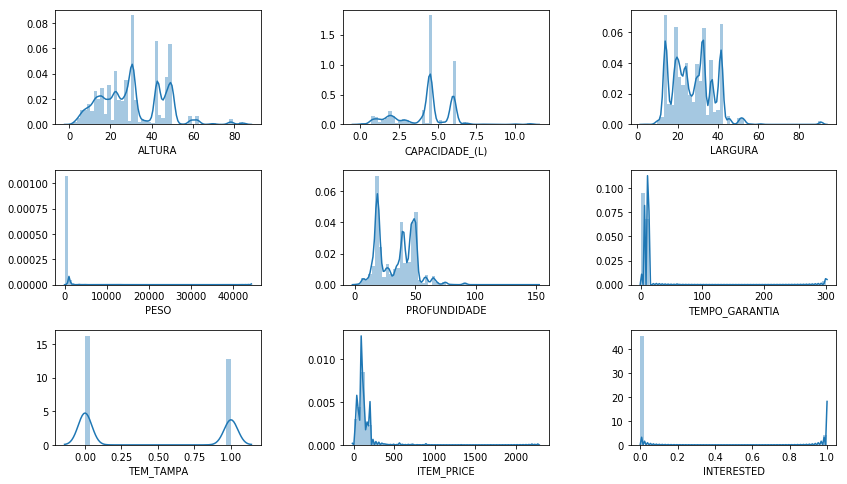

In [0]:
#fig, axes = plt.subplots(nrows = 3, ncols = 3)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_size_inches(14, 8)
for index, variable in enumerate(['ALTURA', 'CAPACIDADE_(L)', 'LARGURA', 'PESO', 
                                  'PROFUNDIDADE', 
                                  'TEMPO_GARANTIA', 'TEM_TAMPA', 'ITEM_PRICE',
                                   'INTERESTED']):
  ax = fig.add_subplot(3,3, index+1)
  sns.distplot(data[variable].dropna(),ax = ax) #axes[count_x,count_y])

  

In [0]:
numeric_features = data.select_dtypes(include=[np.number])
numeric_features.dtypes

ITEM_ID             int64
ALTURA            float64
CAPACIDADE_(L)    float64
LARGURA           float64
PESO              float64
PROFUNDIDADE      float64
TEMPO_GARANTIA    float64
TEM_TAMPA         float64
SESSION_ID        float64
ITEM_PRICE        float64
INTERESTED        float64
dtype: object

Through the dataframe.corr () method it is possible to show the correlation between all numeric attributes of the dataset. We can see a correlation above 0.5 for the height, capacity and, width attributes

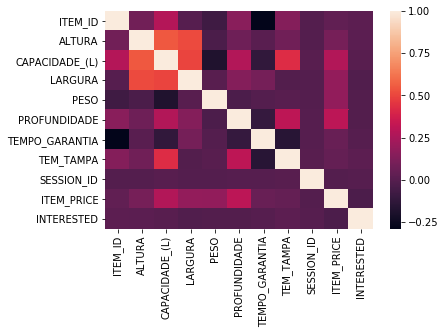

In [0]:
corr = data.corr(method='pearson')
sns.heatmap(corr)

In [0]:
categoricals = data.select_dtypes(exclude=[np.number])
categoricals.describe()

,COMPOSICAO,COR,FORMATO,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,TEM_FERRO_FUNDIDO,TEM_GRELHA,TIPO_PRODUTO,TIPO_WOK
count,180275,180275,180275,180275,180275,180275,180275,180275,180275,180275
unique,5,24,5,35,3,2,2,2,38,2
top,ALUMINIO,INOX,REDONDO,TRAMONTINA,YES,NO,NAO,NAO,PANELA,NAO
freq,137515,44526,170152,73245,150804,175240,154938,160090,62418,144820


In the bottom row, I am using an interpolation method to fill in the null values of numeric attributes: height, width, weight, depth, time_guarantee, price item, session_id. To fill in the null values of the attribute capcity_ (L) we will use the volume equation considering the height, width, and depth of the objects.

In [0]:
columns_feature_numeric =['ALTURA', 'LARGURA', 'PESO',
       'PROFUNDIDADE', 'TEMPO_GARANTIA', 'ITEM_PRICE', 'SESSION_ID']
data[columns_feature_numeric] = data[columns_feature_numeric].interpolate().dropna()
data.dropna(how='any', subset=['ALTURA', 'LARGURA', 'PROFUNDIDADE'], inplace = True)

print(data.isnull().sum())

ITEM_ID                   0
ALTURA                    0
CAPACIDADE_(L)       103603
COMPOSICAO                0
COR                       0
FORMATO                   0
LARGURA                   0
MARCA                     0
PARA_LAVA_LOUCAS          0
PARA_MICRO_ONDAS          0
PESO                      0
PROFUNDIDADE              0
TEMPO_GARANTIA            0
TEM_FERRO_FUNDIDO         0
TEM_GRELHA                0
TEM_TAMPA                 0
TIPO_PRODUTO              0
TIPO_WOK                  0
SESSION_ID                0
ITEM_PRICE                0
INTERESTED                0
dtype: int64


Now let's fill in the null values of the capacity_L attribute. To calculate the capacity in liters of a parallelepiped (rectangular object), let's use the equation = (length * width * height) / 1000 to measure in liters. The same calculation will apply to objects with square shape.

In [0]:
for attribute in ['RETANGULAR', 'QUADRADO']:
  filter_data = data[data['FORMATO']== attribute]
  new_filter_data = filter_data[filter_data['CAPACIDADE_(L)'].isnull()]
  volume_l = new_filter_data['LARGURA'].values * new_filter_data['ALTURA'].values * new_filter_data['PROFUNDIDADE'].values
  data.loc[new_filter_data.index.tolist(), ['CAPACIDADE_(L)']] = volume_l

For the volume of a circle-shaped object will apply the equation

---

V = 4/3 * pi* r^3. Asumindo que r = largura/2.0

In [0]:
for attribute in ['REDONDO', 'OVAL', 'FRIGIDEIRA']:
  filter_data = data[data['FORMATO']== attribute]
  new_filter_data = filter_data[filter_data['CAPACIDADE_(L)'].isnull()]
  raio = new_filter_data['LARGURA']/ 2.0
  volume_l = [(4/3 * 3.14* i**3)/1000.0 for i in raio.values]
  data.loc[new_filter_data.index.tolist(), ['CAPACIDADE_(L)']] = volume_l

print(data.isnull().sum())

ITEM_ID              0
ALTURA               0
CAPACIDADE_(L)       0
COMPOSICAO           0
COR                  0
FORMATO              0
LARGURA              0
MARCA                0
PARA_LAVA_LOUCAS     0
PARA_MICRO_ONDAS     0
PESO                 0
PROFUNDIDADE         0
TEMPO_GARANTIA       0
TEM_FERRO_FUNDIDO    0
TEM_GRELHA           0
TEM_TAMPA            0
TIPO_PRODUTO         0
TIPO_WOK             0
SESSION_ID           0
ITEM_PRICE           0
INTERESTED           0
dtype: int64


**Feature Enginering**
Since that might interfere with the predictive power of our algorithm. In this step, we will remove attributes that are not needed for the model and will also create variable dummies for categorical variables.

To convert categorical text data type into understandable numeric model data, the Label Encoder or One Hot Encoders class can be used. Depending on the data type Label Encoder may present a new problem.

Let's split our data set into the train set with (70%) and the test set with (30%) 

In [0]:
new_data = data.copy()
new_data.drop('INTERESTED', axis=1, inplace=True)
y_real = data['INTERESTED']
train_X,test_X,train_y,test_y=train_test_split(new_data,y_real,test_size=0.30,random_state=200)

The ITEM_PRICE attribute is a continuous attribute that must be transformed into a categorical attribute. The pd.qcut method allows us to properly identify the data intervals considering the number of cuts requested. This function becomes very useful to avoid unbalanced categories.

In [0]:
binned_train_price = pd.qcut(train_X['ITEM_PRICE'].values, 3).value_counts()
binned_test_price = pd.qcut(test_X['ITEM_PRICE'].values, 3).value_counts()
binned_train_peso = pd.qcut(train_X['PESO'].values, 5).value_counts()
binned_test_peso = pd.qcut(test_X['PESO'].values, 5).value_counts()
print('intervals train price',binned_train_price)
print('intervals test price',binned_test_price)
print('intervals tarin peso',binned_train_peso)
print('intervals test peso',binned_test_peso)

intervals train price (0.549, 90.995]     42064
(90.995, 127.9]     42083
(127.9, 2274.99]    42044
dtype: int64
intervals test price (12.344000000000001, 91.436]    18028
(91.436, 129.0]                 18283
(129.0, 2274.99]                17772
dtype: int64
intervals tarin peso (0.618, 120.0]      33164
(120.0, 150.0]      20368
(150.0, 172.0]      22217
(172.0, 322.5]      25252
(322.5, 44400.0]    25190
dtype: int64
intervals test peso (0.618, 120.0]      14258
(120.0, 150.0]       8504
(150.0, 172.5]       9740
(172.5, 320.0]      10796
(320.0, 44400.0]    10785
dtype: int64


In [0]:
category_train = pd.cut(train_X['PESO'].values,
                     bins=[0, 120.0, 150.0, 172.0,322.5, 44400.0],
                     labels=["VERY LIGHT", "LIGHT", "MEDIUM", "HEAVY", "VERY HEAVY"])
category_test = pd.cut(test_X['ITEM_PRICE'].values,
                     bins=[0, 120.0, 150.0, 172.0,322.5, 44400.0],
                     labels=["VERY LIGHT", "LIGHT", "MEDIUM", "HEAVY", "VERY HEAVY"])

train_X.loc[train_X.index, 'PESO_CAT'] =category_train
test_X.loc[test_X.index, 'PESO_CAT'] =category_test
print(train_X.shape)
print(test_X.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(126191, 21)
(54083, 21)


Now let's create categories for the item_price attribute considering the ranges identified.

In [0]:
category_train = pd.cut(train_X['ITEM_PRICE'].values,
                     bins=[0, 90.995, 127.9, 2274.99],
                     labels=["LOW_PRICE", "REGULAR PRICE", "HIGH PRICE"])
category_test = pd.cut(test_X['ITEM_PRICE'].values,
                     bins=[0, 91.436, 129.0, 2274.99],
                     labels=["LOW_PRICE", "REGULAR PRICE", "HIGH PRICE"])

train_X.loc[train_X.index, 'ITEM_PRICE_CAT'] =category_train
test_X.loc[test_X.index, 'ITEM_PRICE_CAT'] =category_test
print(train_X.shape)
print(test_X.shape)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(126191, 22)
(54083, 22)


Due to a large amount of color we have in the products we will apply Label Encoder to the COR attribute for the other attributes we will apply One Hot Encoders.

In [0]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train_X['COR']= labelencoder.fit_transform(train_X['COR']) 
test_X['COR']= labelencoder.fit_transform(test_X['COR']) 
print(train_X.shape)
print(test_X.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(126191, 22)
(54083, 22)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


We will remove item_id, session_id, and item_price attributes. The item_price attributes are correlated with the ITEM_PRICE_CAT attribute.

In [0]:
columns_drop = ['ITEM_ID','SESSION_ID','ITEM_PRICE', 'PESO']
for col in columns_drop:
  train_X.drop(col, axis=1, inplace=True)
  test_X.drop(col, axis=1, inplace=True)

print('was removed the columns selected.')


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


was removed the columns selected.


In [0]:
def dummies_data(df):
  categ_feature_name = ['COMPOSICAO', 'FORMATO', 'MARCA', 'PARA_LAVA_LOUCAS', 
                      'PARA_MICRO_ONDAS', 'TEM_FERRO_FUNDIDO', 'TEM_GRELHA', 
                      'TIPO_PRODUTO', 'TIPO_WOK', 'ITEM_PRICE_CAT', 'PESO_CAT'] 
  #data.select_dtypes(exclude=['int', 'float']).columns
  cat_df=pd.DataFrame()
  for col in categ_feature_name:
    dummy=pd.get_dummies(df[col],prefix=col)
    cat_df=pd.concat([cat_df,dummy],axis=1)
  return cat_df
    
dummie_train_X = dummies_data(train_X)
dummie_test_X = dummies_data(test_X)
numeric_features = train_X.select_dtypes(include=[np.number])
columns_selected = numeric_features.columns.tolist()
train_X = pd.concat([train_X.loc[:, columns_selected],dummie_train_X], axis = 1)
test_X = pd.concat([test_X.loc[:, columns_selected],dummie_test_X], axis = 1)
print(train_X.columns.shape)
print(test_X.columns.shape)


(108,)
(108,)


The code below allows identifying which categorical attributes have a correlation above 0.8. Once identified we will remove them. We can observe that the result is an empty vector. This means that there are no correlated attributes in our training set.

In [0]:
correlation_matrix = train_X.corr()
correlated_features = []
for i in range(len(categ_feature_name)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.append(colname)
print(correlated_features)

[]


**Feature selection**

In this step, we will use the LightGBM algorithm to identify the most relevant categorical attributes, ie those that most impact the model. This step is very important because many attributes can delay training, make a model less interpretable, and most critically, reduce the performance of model generalization in the test suite. When we have irrelevant resources, they drown out the important variables, and as the number of resources increases, the number of data points needed for the model to learn the relationship between data and destination grows exponentially.



LightGBM is a boosting algorithm. In this type of algorithm, the weight assigned to an individual classifier depends on the weighted sum of the misclassified points error for that classifier. In gradient boosting it is important to use the learning rate for optimal output. Therefore the learning rate should be low but not too low otherwise the algorithm will take so long to complete the training as it is necessary to increase the numerical trees.


In [0]:

model =LGBMClassifier(learning_rate=0.05,n_estimators=250,n_jobs=-1,reg_alpha=0.1,min_split_gain=0.01,verbose=-1)
model.fit(train_X,train_y)
print('Createing a LGBM classifier on categorical data')
print('roc auc score:',roc_auc_score(test_y,model.predict_proba(test_X)[:,1]))

Createing a LGBM classifier on categorical data
roc auc score: 0.610547667136168


Using the SelectFromModel function and indicating a threshold the function returns a list of the most relevant features. From a total of over 100 features, 46 relevant attributes were found.

In [0]:
embeded_lgb_selector = SelectFromModel(model, threshold='1.25*median')
embeded_lgb_selector.fit(train_X,train_y)
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = train_X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

46 selected features


In the figure below we can see a plot that indicates the relevance of each categorical attribute in the model. As we can see in the chart attributes such as warranty time, product dimensions and low to medium price are the attributes that have the greatest impact on the model. We also note that among the product types the type of product like 'cacerola', 'panela' are also of interest to people.


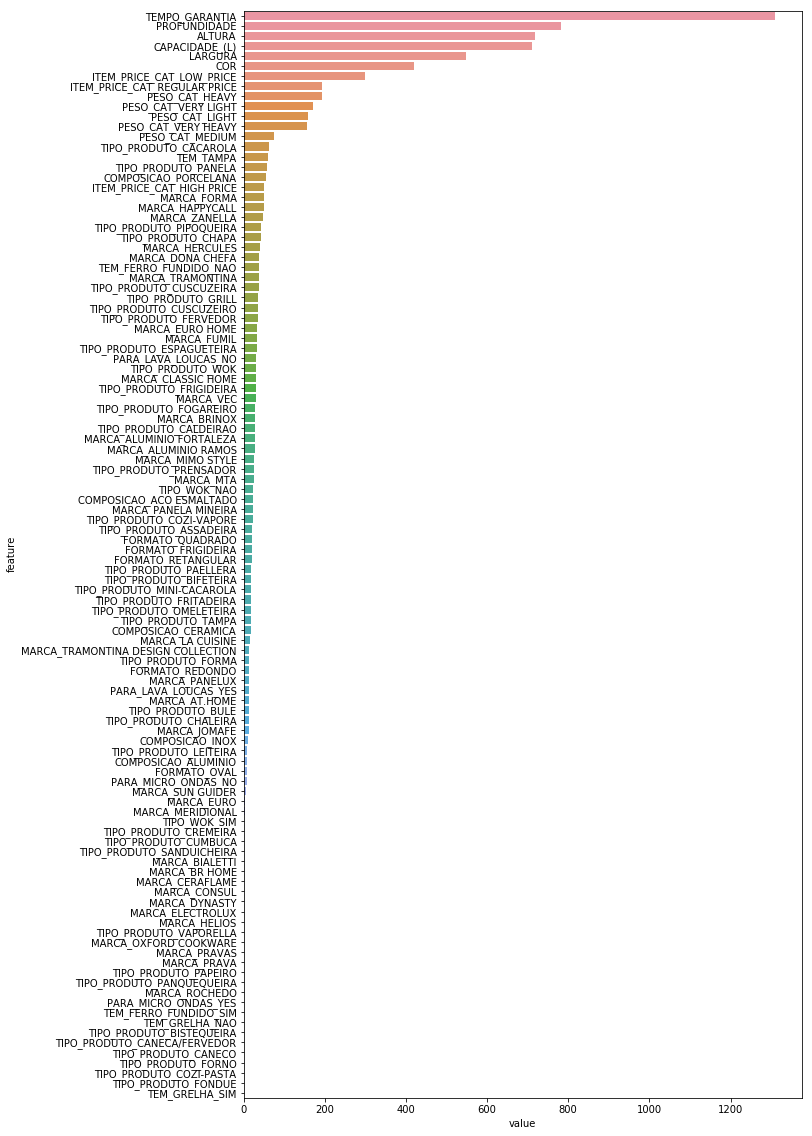

In [0]:
import matplotlib.pyplot as plt
feat_importance = pd.DataFrame()
feat_importance["feature"] = train_X.columns
feat_importance["value"] = model.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(10,20))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

**Modelling**

At this stage of modeling, I decided to use the ensemble-based methods. These algorithms construct a set of classifiers whose decisions are combined into a single decision (weightless votes or average votes) by sorting new data considering the votes of their predictions. Usually, it gets better results than a single classifier. For an ensemble to be good it must be accurate and diverse. An accurate classifier is one that has a better error rate than guessing randomly about new x values and is different if each classifier makes errors that are not correlated with the other classifiers.


**Random Forest Classifier**

In order to find the best parameters for our model, we can use the RandomSerach or GridSearch algorithm.

In [0]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier()
param_model = {"max_depth": [5, 10, 15, 20],
               "min_samples_split": [n for n in range(4, 10)],
               'min_samples_leaf': [1, 3, 5, 7],
               "n_estimators": [n for n in range(50, 100, 200)],
               "criterion": ["gini"]
              }

**Considering as an accuracy measure we observed that the best score was approximately 91%, but as we have an imbalance in the predicted class we cannot use the accuracy measure as a metric to evaluate the predictive power of our model. In our case the best measure to consider is to find the area under the curve(auc)**

In [0]:

rf_model = RandomizedSearchCV(RandomForest, param_model, scoring= "accuracy")
rf_model.fit(train_X.loc[:, embeded_lgb_feature], train_y)
random_forest_best = rf_model.best_estimator_
print('best_score:', rf_model.best_score_ )

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


best_score: 0.9131237568447829


We consider as an evaluation measure the area under the curve. This measure is very useful when there is a disproportion between the predicted class. Using the RandomForest algorithm we obtained an AUC of 0.60. The higher the AUC (Area under the curve) value, the better the predictive power of the model.

In [0]:
auc = roc_auc_score(train_y,rf_model.predict_proba(train_X.loc[:, embeded_lgb_feature])[:,1])
print('AUC train data', auc)
auc = roc_auc_score(test_y,rf_model.predict_proba(test_X.loc[:, embeded_lgb_feature])[:,1])
print('AUC Test data:  ', auc)

AUC train data 0.7095255161916607
AUC Test data:   0.5952554012820166
